In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.special import jv
from scipy.integrate import simps

In [2]:
year = 3.1536e7               #Seconds in a year
M_sun = 1.9891e30             #Mass of sun in kg
M_Ch = 1.435 * M_sun          #Chandra Mass in kg
G = 6.6743e-11                #gravitational constant in m^3/kg/s^2
c = 299792458                 #speed in m/s
D = 3.086e19                  #Distance in meters (1 kpc)
m1 = 0.5 * M_sun              #Mass of WD1 in kg
m2 = 0.5 * M_sun              #Mass of WD2 in kg
mu = (m1 * m2)/(m1 + m2)      #Reduced Mass of system in kg
M = m1 + m2                   #Total mass of system in kg
radius = ((7.8e8*((m1/M_Ch)**(-1/3))*((1-((m1/M_Ch)**(4/3)))**(1/2)))/100)              #Radius of the stars (m) 
fres = 1 / (5 * year)         #Frequency resolution 

In [3]:
# Define the range of values for the x (e) and y (nu) axes
min_e, max_e = 0, 0.98  # Example range for e
min_nu, max_nu = 0.0001, 0.0225  # Example range for nu
num_points = 100  # Number of points in each axis

In [4]:
# Create the grid of initial conditions
e_values = np.linspace(min_e, max_e, num_points)
log_nu_values = np.linspace(np.log10(min_nu), np.log10(max_nu), num_points)
e_grid, log_nu_grid = np.meshgrid(e_values, log_nu_values)

In [5]:
#Define our differential equations
def dnudt(e0, nu0):
    dnudt = (96/(10*np.pi))*(((c**6)*mu)/((M**3)*(G**2)))*((2*np.pi*(G*M/(c**3)*nu0))**(11/3))*((1-(e0**2))**(-9/2))*((1+((73/24)*(e0**2))+((37/96)*(e0**4)))*(1-(e0**2)))
    return dnudt

def dedt(e0, nu0):
    dedt = -1*(e0/15)*(((c**3)*mu)/((M**2)*G))*((1-(e0**2))**(-7/2))*((2*np.pi*(G*M/(c**3)*nu0))**(8/3))*((304+(121*(e0**2)))*(1-(e0**2)))
    return dedt

In [6]:
#Define the characteristic time
def calculate_t_char(e0, nu0):
    t_char = nu0 / dnudt(e0, nu0)
    return t_char

t_M = (G * M)/(c**3)

In [7]:
#Define our coupled differential equations to solve
#Must declare t_char as an initial condition with a zero derivative or else solve_ivp gets very mad
def coupled_odes(t, y):
    A, e, t_char = y
    
    dAdt  = (96/(10*np.pi))*((t_char/t_M)*(mu/M))*((2*np.pi*A)**(11/3))*((1-(e**2))**(-9/2))*((1+((73/24)*(e**2))+((37/96)*(e**4)))*(1-(e**2)))
    
    dedt = -1*(e/15)*((t_char/t_M)*(mu/M))*((1-(e**2))**(-7/2))*((2*np.pi*A)**(8/3))*((304+(121*(e**2)))*(1-(e**2)))
    
    dt_chardt = 0
    
    return [dAdt, dedt, dt_chardt]

In [8]:
def S(n, nu):
    fa = 0.0004
    fb = 0.025

    A = 1.28e-44
    alpha = 1.63
    a1 = -0.224
    b1 = -2.704
    ak = -0.361
    bk = -2.378

    T = 5

    f1 = 10**((a1*np.log10(T))+b1)
    f2 = 10**(-3.318)
    fk = 10**((ak*np.log10(T))+bk)

    S1 = 5.76e-48 * (1 + ((fa/(n*nu))**2))     #s^-4 Hz^-1
    S2 = 3.60e-41                              #Hz^-1
    R  = 1 + (((n*nu)/fb)**2)                  #unitless
    
    S = ((1/2) * (20/3) * ((S1/((2*np.pi*(n*nu))**4)) + S2) * R)
    
    return S

In [9]:
#Define relative harmonic strength term
def g(n, e):
    g = ((n**4)/32)*((((jv(n-2,(n*e)))-(2*e*(jv(n-1,(n*e))))+((2/n)*(jv(n,(n*e))))+(2*e*(jv(n+1,(n*e))))-((jv(n+2,(n*e)))))**2)+(((1-(e**2))*((jv(n-2,(n*e)))-(2*(jv(n,(n*e)))+(jv(n+2,(n*e))))))**2)+((4/(3*(n**2)))*(((jv(n,(n*e))))**2)))
    return g

In [10]:
#Define fdot
def fdot(n, nu, e):
    fdot = n * dnudt(e, nu)
    return fdot

In [11]:
#Define Edot
def Edot(n, nu, e):
    Edot = ((32/5)*((G**(7/3))/(c**5))*(mu**2)*(M**(4/3))*((2*np.pi*(nu))**(10/3))*g(n, e))
    return Edot

In [12]:
#Define h(c,n)
def h(n, nu, e):
    h = (((G**(1/2))/(c**(3/2)))*(np.sqrt((2*Edot(n, nu, e))/fdot(n, nu, e))))/(np.pi*D)
    return h

def h2(n, nu, e):
    h2 = (h(n, nu, e))**2
    return h2

In [13]:
#Define SNR2
def SNR_fraction(n, nu, e):
    fraction = h2(n, nu, e) / (5 * n*nu * S(n, nu))
    return fraction

In [19]:
# Perform the integration using a loop over the grid of initial conditions
SNR = np.zeros_like(e_grid)
SNR_2 = np.zeros_like(e_grid)
SNR_3 = np.zeros_like(e_grid)

In [25]:
#Assuming a 100 point mesh grid, this should take between 10 - 15 seconds to run on MSU Filament
#Assuming a 10,000 point mesh grid, this should take ~20 minutes to run on MSU Filament 

for i in range(num_points):
    for j in range(num_points):
        e0 = e_grid[i, j]
        log_nu0 = log_nu_grid[i, j]
        nu0 = 10**log_nu0
        
        # Calculate the constant for the current initial condition
        t_char = calculate_t_char(e0, nu0)
        A0 = t_M * nu0
        #Initial Time
        t0 = 0
        #Final Time
        tf = (5 * year)/t_char
        #Define a time frame
        t_span = [t0, tf]
        #times = np.linspace(t0,tf,10000)
        
        # Solve the differential equations for each initial condition
        sol = solve_ivp(coupled_odes, t_span, [A0, e0, t_char])
        
        # Extract the solution
        e_solution = sol.y[1]
        nu_solution = sol.y[0] / t_M
        
        #Find the range of nu evolution for every set of initial conditions for integration
        #nu = np.linspace(nu_solution[0], nu_solution[-1], 1000)
        #e  = np.linspace(e_solution[0], e_solution[-1], 1000)
        
        nu = nu_solution
        e = e_solution

        #
        harmonic_range = range(1,21)
        total_value = 0.0
        
        for n in harmonic_range:

            value = simps(SNR_fraction(n, nu, e), np.log(n*nu))
            total_value += value
            
            if n==2:
                _SNR_2 = value+0
            
        #
        a = np.cbrt(((1/nu_solution[-1])**2)*((G*M)/(4*(np.pi**2))))
        separation = a * (1 - e_solution[-1])
        
        if separation <= 2 * radius:
            total_value = np.NaN
            _SNR_2 = np.NaN
        
        delta_nu = nu_solution[-1] - nu0
        
        if delta_nu <= fres:
            total_value = np.NaN
            _SNR_2 = np.NaN
            
        #if total_value <= 1:
            #total_value = 0
            
        #
        SNR[i, j] = np.log10(np.sqrt(total_value))
        SNR_2[i, j] = np.log10(np.sqrt(_SNR_2))
        SNR_3[i, j] = np.log10(np.sqrt(total_value - _SNR_2))

/tmp/ipykernel_32622/161618429.py:67: RuntimeWarning: divide by zero encountered in log10
  SNR_3[i, j] = np.log10(np.sqrt(total_value - _SNR_2))
/tmp/ipykernel_32622/161618429.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  SNR_4[i, j] = (np.sqrt((_SNR_2)/(total_value - _SNR_2)))
/tmp/ipykernel_32622/2456728461.py:6: RuntimeWarning: invalid value encountered in scalar power
  dAdt  = (96/(10*np.pi))*((t_char/t_M)*(mu/M))*((2*np.pi*A)**(11/3))*((1-(e**2))**(-9/2))*((1+((73/24)*(e**2))+((37/96)*(e**4)))*(1-(e**2)))
/tmp/ipykernel_32622/2456728461.py:8: RuntimeWarning: invalid value encountered in scalar power
  dedt = -1*(e/15)*((t_char/t_M)*(mu/M))*((1-(e**2))**(-7/2))*((2*np.pi*A)**(8/3))*((304+(121*(e**2)))*(1-(e**2)))


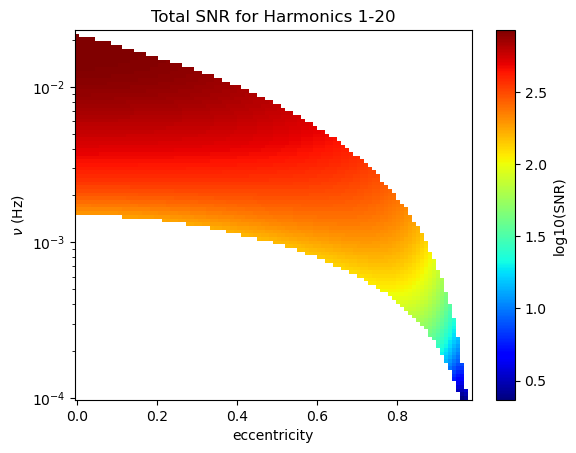

In [21]:
# Create a color plot of the integral values
plt.pcolormesh(e_grid, 10**log_nu_grid, SNR, cmap='jet')
plt.colorbar(label='log10(SNR)')
plt.xlabel('eccentricity')
plt.ylabel(r'$\nu$ (Hz)')
plt.yscale('log')
#plt.suptitle('Resolvable Systems Only')
plt.title(r'Total SNR for Harmonics 1-20')
plt.show()

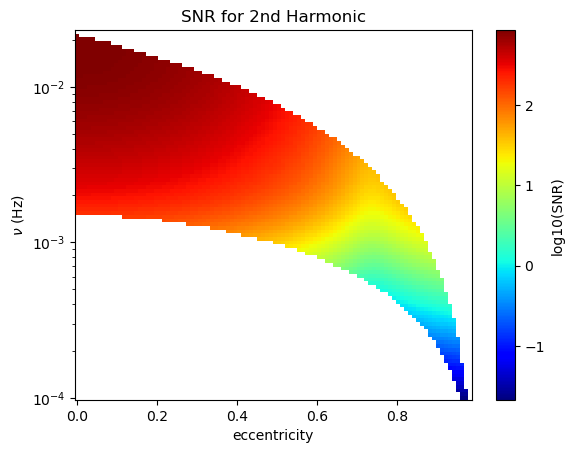

In [22]:
# Create a color plot of the integral values
plt.pcolormesh(e_grid, 10**log_nu_grid, SNR_2, cmap='jet')
plt.colorbar(label='log10(SNR)')
plt.xlabel('eccentricity')
plt.ylabel(r'$\nu$ (Hz)')
plt.yscale('log')
#plt.suptitle('Resolvable Systems Only')
plt.title(r'SNR for 2nd Harmonic')
plt.show()

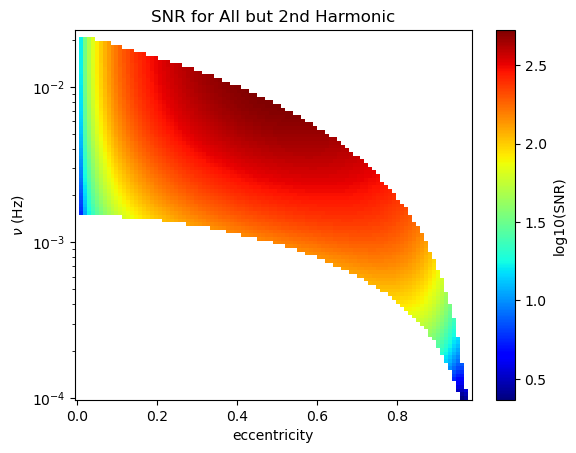

In [23]:
plt.pcolormesh(e_grid, 10**log_nu_grid, SNR_3, cmap='jet')
plt.colorbar(label='log10(SNR)')
plt.xlabel('eccentricity')
plt.ylabel(r'$\nu$ (Hz)')
plt.yscale('log')
#plt.suptitle('Resolvable Systems Only')
plt.title(r'SNR for All but 2nd Harmonic')
plt.show()